# Equivariant Machine Learned Interatomic Potentials Models

Created by ***Debsundar Dey*** and ***Tejus Rohatgi***

This tutorial aims to demonstrate two state-of-the-art MLIP models, **NequIP** and **MACE**.


## Table of Contents
0. [Before Starting](#prep)
1. [Dataset](#dataset)
    *   [Silicon Dataset](#silicon)
    *   [Visualising Dataset](#visualise)
    *   [Splitting Dataset into Training and Testing Set](#split)
2. [NequIP](#nequip)
    * [Introduction](#nequip-intro)
    * [Installing NequIP](#nequip-install)
    * [Configuration](#nequip-config)
    * [Training NequIP](#nequip-training)
    * [Molecular Dynamics using NequIP](#nequip-md)
3. [MACE](#mace)
    * [Introduction](#mace-intro)
    * [Installing MACE](#mace-install)
    * [Configuration](#mace-config)
    * [Training MACE](#mace-training)
    * [Molecular Dynamics using MACE](#mace-md)
    * [MACE Foundational Models](#mace-foundational)
4. [Exercises](#exercises)
    * [Evaluating NequIP and MACE](#ex-evaluate)
    * [Play with the hyperparamters for NequIP and MACE. ](#ex-hyperparam)
    * [Training complex datasets](#ex-botnet)
5. [BONUS: Visualizing `.xyz` files](#ovito)
    





## 0. Before Starting <a name="prep"></a>

### Enable GPU

Training NequIP and MACE requires GPU acceleration as they are a highly complex deep neural networks. To enable GPU turn on the `T4 GPU` before running the first block.



In [1]:
# Install necessary packages and dependencies
!pip install ase
!pip install e3nn==0.4.4
!pip install opt_einsum
!pip install torch_ema
!pip install prettytable

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.7/387.7 kB 8.8 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import ase
import random
import time
import pylab as pl
import torch

In [3]:
# Determine device is CPU or GPU
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Dataset <a name="dataset"></a>
The dataset plays a crucial role in training and evaluating Machine Learning Interatomic Potential (MLIP) models. Its quality, diversity, and relevance significantly impact the performance and generalizability of the MLIP. The dataset provides the atomic configurations and corresponding properties (e.g., energy, forces, stress) that the MLIP aims to predict.


### 1.1. Silicon Dataset <a name="silicon"></a>
High-temperature Si data set sampled with AIMD at T = 800 K, consisting of 64 atoms per frame.

In [4]:
%%capture
# download data
!gdown --folder --id --no-cookies https://drive.google.com/drive/folders/1FEwF4i8IDHGmAIQ3RilA0jG9_lEX4Yk0?usp=sharing
!mkdir Si_data
!mv *.xyz ./Si_data

In [5]:
!ls Si_data

sitraj.xyz


In [6]:
# Defining path to dataset for ease
dataset_dir = Path(os.getcwd()) / 'Si_data'

### 1.2. Visualising Dataset <a name="visualise"></a>

We will utilise the `ase` package to get more information about the datset we are looking on. Let's start with `dataset_acac/train_300K.xyz`.



In [7]:
from ase.io import read, write

# Load the dataset
dataset = read("Si_data/sitraj.xyz", index=":")
dataset[0]

Atoms(symbols='Si64', pbc=True, cell=[10.861999859992501, 10.861999859992501, 10.861999859992501], calculator=SinglePointCalculator(...))

In [8]:
num_configs = len(dataset)
print(f"Number of configurations in the dataset: {num_configs}")

Number of configurations in the dataset: 110


Let's utilise `ase.visualize` module to visualize the first few configurations in the datset.

In [9]:
from ase.visualize import view

view(dataset[0], viewer='x3d')

### 1.3. Splitting Dataset into Training and Testing Set <a name="split"></a>

In [10]:
# Randomly shuffle the list in place
random.seed(123)
random.shuffle(dataset)

# Split into train (first 100) and test (last 10)
train_set = dataset[:100]
test_set = dataset[100:]

train_data = dataset_dir / "Si_train.xyz"
test_data = dataset_dir / "Si_test.xyz"

# Write them out to separate .xyz files
write(train_data, train_set)
write(test_data, test_set)

## 2. NequIP <a name="nequip"></a>




### 2.1. Introduction <a name="nequip-intro"></a>

Welcome to the *NequIP Tutorial with Molecular Dynamics*, where we’ll train a NequIP model with AIMD data and use it for MD simulations! Think of this as a speedrun through the molecular jungle—we might skip some scenic routes (a.k.a. deep physical intuition), but we’ll get you to the finish line with a working model. So buckle up, and let’s dive into the NequIPverse.

#### About NequIP

NequIP employs E(3)-equivariant graph neural networks, which respect the symmetries of three-dimensional Euclidean space (rotations, translations, and reflections). This allows the model to learn both scalar (e.g., energy) and vector (e.g., forces) properties in a symmetry-aware manner.

### 2.2. Installing NequIP <a name="nequip-install"></a>

In [11]:
# Clone NequIP
!git clone https://github.com/mir-group/nequip.git

# Install NequIP
!cd nequip && pip install .

Cloning into 'nequip'...
remote: Enumerating objects: 14013, done.
remote: Counting objects: 100% (4358/4358), done.
remote: Compressing objects: 100% (559/559), done.
remote: Total 14013 (delta 4037), reused 3910 (delta 3799), pack-reused 9655 (from 2)
Receiving objects: 100% (14013/14013), 3.88 MiB | 6.94 MiB/s, done.
Resolving deltas: 100% (10184/10184), done.
Processing /content/nequip
  Preparing metadata (setup.py) ... done
  Created wheel for nequip: filename=nequip-0.6.1-py3-none-any.whl size=175386 sha256=817d18934569fb8870f1433f066dce2bde3d8510b27fc07f62120d0c3887d95d
  Stored in directory: /tmp/pip-ephem-wheel-cache-c5pfi619/wheels/11/64/44/9d30bacb0803dffa7821bb8685dbc60a0830cca339476e4e86
Successfully built nequip


In [12]:
!ls nequip

build	      configs	       docs	 LICENSE   nequip	    README.md  setup.py
CHANGELOG.md  CONTRIBUTING.md  examples  logo.png  nequip.egg-info  setup.cfg  tests


### 2.3. Configuration <a name="nequip-config"></a>

In [13]:
# Specify Paths
nequip_dir = Path(os.getcwd()) / 'nequip'
nequip_configs_dir = nequip_dir / 'configs'
nequip_results_dir = nequip_dir / 'results'

# Create directories if not exists
os.makedirs(nequip_configs_dir, exist_ok=True)
os.makedirs(nequip_results_dir, exist_ok=True)

#### 2.3.1. Hyperparameters in Training NequIP <a name="nequip-hypparam"></a>

In [14]:
# Specifying parameters for training a NequIP model

parameters_nequip = {

    # Specify model name and save directories
    "root": str(nequip_results_dir),
    "run_name": "si",

    # Dataset
    "dataset": "ase",
    "dataset_file_name": str(train_data),

    "key_mapping": {
        "z": "atomic_numbers",
        "E": "total_energy",
        "F": "forces",
        "R": "pos",
    },
    "chemical_symbols": ["Si"],


    # Hyperparameters
    "num_features": 64, # Number of channels determining the size of the model
    "r_max": 4.0,  # Maximum interaction radius
    "l_max": 1, # Symmetry of messages
    "parity": "true", # whether to include features with odd mirror parity
    "num_layers": 4,  # Number of message-passing layers in the model
    # radial network
    "num_basis": 8, # number of basis functions used in the radial basis, 8 usually works best
    "invariant_layers": 2, # number of radial layers, usually 1-3 works best, smaller is faster
    "invariant_neurons": 64,  # number of hidden neurons in radial function, smaller is faster

    # Optimization
    "n_train": "80%", # Fraction of the training set to use as training
    "n_val": "20%", # Fraction of the training set to use as validation
    "batch_size": 10, # Batch size for training
    "max_epochs": 50, # Maximum number of epochs
    "default_dtype": "float64", # Precision for calculations
    "model_dtype": "float32",
    "wandb": False, # Logging
    "device": device, # Device to use ("cuda" for GPU)
    "seed": 123,
    "dataset_seed": 123,

    # Output Metrics
    "metrics_components": [
        ["forces", "mae"],
        ["forces", "rmse"],
        ["total_energy", "mae"],
        ["total_energy", "rmse"]
    ],
}


# Save parameters to a YAML file
input_nequip = nequip_configs_dir / "input.yaml"

with open(input_nequip, "w") as file:
    yaml.dump(parameters_nequip, file, default_flow_style=False)

print(f"Parameters have been saved to {input_nequip}")


Parameters have been saved to /content/nequip/configs/input.yaml


### 2.4. Training NequIP <a name="nequip-train"></a>

To train a NequIP model, you can use the `nequip-train` file.

In [15]:
%%time
!nequip-train nequip/configs/input.yaml

/usr/local/lib/python3.10/dist-packages/nequip/__init__.py:20: UserWarning: !! PyTorch version 2.5.1 found. Upstream issues in PyTorch versions 1.13.* and 2.* have been seen to cause unusual performance degredations on some CUDA systems that become worse over time; see https://github.com/mir-group/nequip/discussions/311. The best tested PyTorch version to use with CUDA devices is 1.11; while using other versions if you observe this problem, an unexpected lack of this problem, or other strange behavior, please post in the linked GitHub issue.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the d

**Extra:** Try running the model with different hyperparameters.

In [16]:
# Check the output files
nequip_train_dir = nequip_results_dir / parameters_nequip["run_name"]
for file in nequip_train_dir.rglob("*"):
    print(file)

/content/nequip/results/si/best_model.pth
/content/nequip/results/si/trainer.pth
/content/nequip/results/si/log
/content/nequip/results/si/metrics_batch_train.csv
/content/nequip/results/si/metrics_epoch.csv
/content/nequip/results/si/metrics_initialization.csv
/content/nequip/results/si/metrics_batch_val.csv
/content/nequip/results/si/last_model.pth
/content/nequip/results/si/config.yaml


Check the file saved as `metric_epoch.csv` for information of about training.

In [17]:
nequip_train_csv = nequip_train_dir / "metrics_epoch.csv"

# Load the CSV file
df = pd.read_csv(nequip_train_csv)

df.head()

,epoch,wall,LR,training_loss_e,training_loss,training_f_mae,training_f_rmse,training_e_mae,training_e_rmse,validation_loss_e,validation_loss,validation_f_mae,validation_f_rmse,validation_e_mae,validation_e_rmse
0,1,8.057,0.01,3033.300,3033.300,0.749,0.960,41.50,49.90,1126.700,1126.700,0.785,0.977,30.40,30.40
1,2,8.983,0.01,343.000,343.000,0.720,0.908,14.00,16.80,246.880,246.880,0.705,0.879,14.20,14.20
2,3,9.929,0.01,114.700,114.700,0.699,0.882,8.84,9.71,68.796,68.796,0.724,0.903,7.51,7.52
3,4,10.861,0.01,43.808,43.808,0.700,0.883,5.47,6.00,25.120,25.120,0.717,0.893,4.52,4.55
4,5,11.790,0.01,16.724,16.724,0.705,0.888,3.35,3.71,11.513,11.513,0.723,0.902,3.04,3.08


In [18]:
df.columns

Index(['epoch', ' wall', ' LR', 'training_loss_e', 'training_loss',
       'training_f_mae', 'training_f_rmse', 'training_e_mae',
       'training_e_rmse', 'validation_loss_e', 'validation_loss',
       'validation_f_mae', 'validation_f_rmse', 'validation_e_mae',
       'validation_e_rmse'],
      dtype='object')

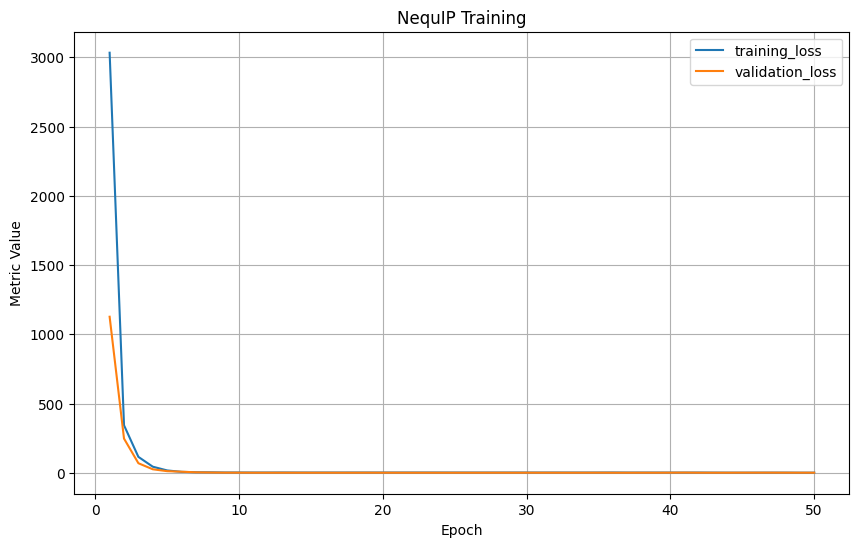

In [19]:
# Columns to plot
metrics = [
    # 'training_loss_e',
    'training_loss',
    #  'training_f_mae',
    #  'training_f_rmse',
    #  'training_e_mae',
    #  'training_e_rmse',
    #  'validation_loss_e',
    'validation_loss',
    #  'validation_f_mae',
    #  'validation_f_rmse',
    #  'validation_e_mae',
    #  'validation_e_rmse',
    ]

# Plot each metric against the epoch
plt.figure(figsize=(10, 6))
for metric in df.columns:
    if metric in metrics:
        plt.plot(df['epoch'], df[metric], label=metric)

# Add labels, title, and legend
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('NequIP Training')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### 2.5. Molecular Dynamics using NequIP <a name="nequip-md"></a>


Molecular dynamics (MD) is a computer simulation technique used to model and analyze the physical movements of atoms and molecules over time. By applying the principles of classical mechanics, specifically Newton's equations of motion, MD calculates the trajectories of particles based on the forces acting between them. These forces are typically derived from potential energy functions that describe interactions such as bonding, electrostatics, and van der Waals forces. The MLIPs are the potential energy functions we are using here.

#### 2.5.1. ASE Molecular Dynamics <a name="nequip-md-ase"></a>

We will be using ASE (Atomic Simulation Environment) for performing a simple MD simulations using the module [`ase.md`](https://wiki.fysik.dtu.dk/ase/ase/md.html).

The function `simpleMD()` is based on this [tutorial](https://colab.research.google.com/drive/1ZrTuTvavXiCxTFyjBV4GqlARxgFwYAtX).

In [20]:
from ase import units
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import Stationary, ZeroRotation, MaxwellBoltzmannDistribution
from ase.calculators.calculator import Calculator
from IPython import display

def simpleMD(
    init_conf: ase.Atoms,
    temp: float,
    calc: Calculator,
    fname: str,
    s: int,
    T: int,
    seed = 123,
    init_temp = 300,
    friction = 0.1,
    ) -> None:
    """
    Perform a simple molecular dynamics (MD) simulation using the Langevin thermostat.

    Parameters:
    -----------
    init_conf : Initial atomic configuration to start the simulation.
    temp :  Target temperature of the system in Kelvin.
    calc :  Calculator to compute forces and energies for the simulation.
    fname :  Filename to store the trajectory (.xyz format).
    s :  Interval (in steps) to save frames and update the plot.
    T :  Total number of MD steps to run.
    seed: To ensure reproducibiity
    init_temp: Initialization temperature
    friction: Damping factor in Langevin

    Returns: None
    """

    # Assign the calculator for force and energy calculations
    init_conf.set_calculator(calc)

    # Initialize the temperature of the system
    random.seed(123)  # Seed for reproducibility
    MaxwellBoltzmannDistribution(init_conf, temperature_K=init_temp)  # Initial temp 300 K
    Stationary(init_conf)  # Remove net momentum
    ZeroRotation(init_conf)  # Remove angular momentum

    # Set up the Langevin thermostat
    dyn = Langevin(init_conf, 1.0 * units.fs, temperature_K=temp, friction=friction)

    # Required for inline plotting in Jupyter Notebook
    %matplotlib inline

    # Initialize lists to store time, temperature, and energy
    time_fs = []
    temperature = []
    energies = []

    # Remove any existing trajectory file with the same name
    os.system("rm -rfv " + fname)

    # Create a plot with two subplots
    fig, ax = pl.subplots(2, 1, figsize=(10, 6), sharex="all", gridspec_kw={"hspace": 0, "wspace": 0})

    def write_frame():
        """
        Function to save a frame of the trajectory and update the live plot.
        """
        dyn.atoms.write(fname, append=True)  # Append current configuration to file
        time_fs.append(dyn.get_time() / units.fs)  # Store current simulation time
        temperature.append(dyn.atoms.get_temperature())  # Store current temperature
        energies.append(dyn.atoms.get_potential_energy() / len(dyn.atoms))  # Potential energy per atom

        # Update the plot
        ax[0].plot(np.array(time_fs), np.array(energies), color="b")
        ax[0].set_ylabel("E (eV/atom)")

        ax[1].plot(np.array(time_fs), temperature, color="r")
        ax[1].set_ylabel("T (K)")
        ax[1].set_xlabel("Time (fs)")
        ax[1].axhline(y=temp, linestyle = '--', c = "black")

        # Clear the previous plot and display the updated one
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(0.01)  # Pause for a short time to make the updates visible

    # Attach the write_frame function to be called every `s` steps
    dyn.attach(write_frame, interval=s)

    # Run the MD simulation and time its execution
    t0 = time.time()
    dyn.run(T)
    t1 = time.time()

    print("MD finished in {0:.2f} minutes!".format((t1 - t0) / 60))

We use Langevin thermostat using [`ase.md.langevin.Langevin`](https://wiki.fysik.dtu.dk/ase/ase/md.html#module-ase.md.langevin).

[Langevin dynamics](https://en.wikipedia.org/wiki/Langevin_dynamics) is a computational simulation method used to model the behavior of particles in a system by incorporating both deterministic and stochastic (random) forces. It extends classical molecular dynamics (MD) by introducing additional terms to account for the interaction of particles with their surrounding environment, typically represented as a heat bath. This approach is particularly useful for simulating systems at a constant temperature and for capturing the effects of thermal fluctuations and friction without explicitly modeling every component of the environment.

\begin{equation}
M \ddot{\mathbf{X}} = -\nabla U(\mathbf{X}) - \gamma M \dot{\mathbf{X}} + \sqrt{2 M \gamma k_{\mathrm{B}} T} \, \mathbf{R}(t),
\end{equation}


#### 2.5.2. Deploying NequIP Model <a name="nequip-md-deploy"></a>
The `nequip-deploy` command is used to deploy the result of a training session into a model that can be stored and used for inference. It compiles a NequIP model trained in Python to TorchScript. The result is an optimized model file that has no dependency on the nequip Python library, or even on Python itself

In [21]:
!nequip-deploy build \
--train-dir nequip/results/si/  nequip/results/si/deployed_model.pth

/usr/local/lib/python3.10/dist-packages/nequip/__init__.py:20: UserWarning: !! PyTorch version 2.5.1 found. Upstream issues in PyTorch versions 1.13.* and 2.* have been seen to cause unusual performance degredations on some CUDA systems that become worse over time; see https://github.com/mir-group/nequip/discussions/311. The best tested PyTorch version to use with CUDA devices is 1.11; while using other versions if you observe this problem, an unexpected lack of this problem, or other strange behavior, please post in the linked GitHub issue.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the d

#### 2.5.3. NequIP Calculator <a name="nequip-md-calc"></a>
NequIP models can run molecular dynamics or geometry optimisation through the ASE calculator.

In [22]:
init_conf = read(test_data, index=0)
init_conf

Atoms(symbols='Si64', pbc=True, cell=[10.861999859992501, 10.861999859992501, 10.861999859992501], calculator=SinglePointCalculator(...))

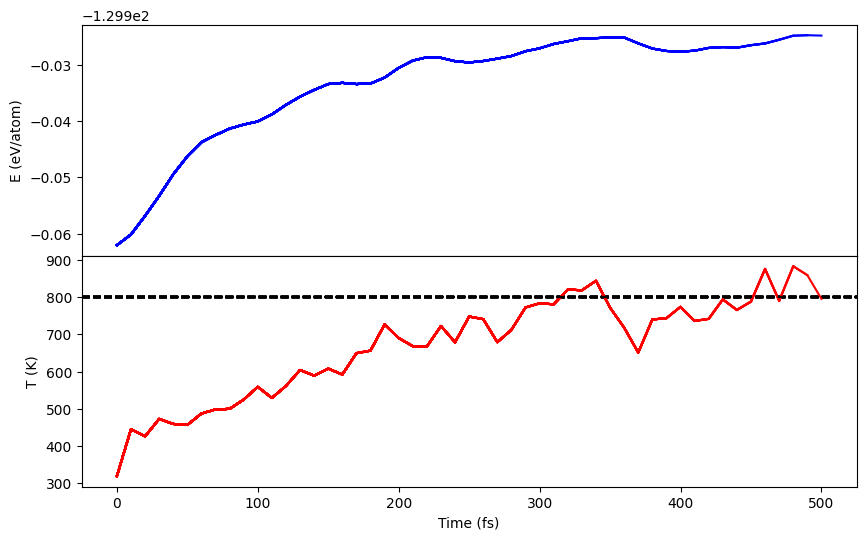

MD finished in 1.93 minutes!


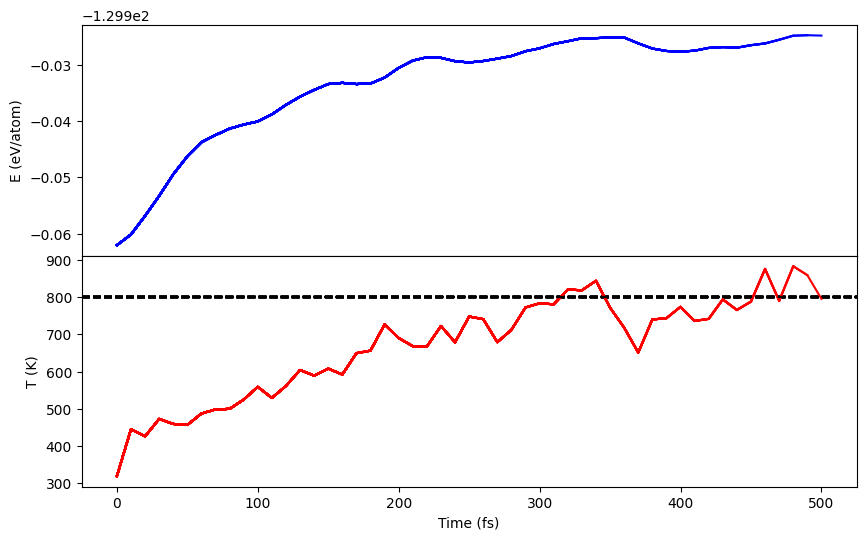

In [24]:
from nequip.ase import NequIPCalculator

# Specify the path to the pre-trained MACE model
nequip_model = nequip_train_dir / "deployed_model.pth"

# Initialize the NequIP calculator with the specified model
nequip_calc = NequIPCalculator.from_deployed_model(nequip_model)

# Call the simpleMD function to perform a molecular dynamics simulation
simpleMD(init_conf, temp=800, calc=nequip_calc, fname= 'nequip/results/nequip_md_si_800K.xyz', s=10, T=500)

## 3. MACE <a name="mace"></a>

### 3.1. Introduction <a name="mace-intro"></a>
#### About MACE

[MACE](https://proceedings.neurips.cc/paper_files/paper/2022/hash/4a36c3c51af11ed9f34615b81edb5bbc-Abstract-Conference.html) is a machine learning interatomic potential (MLIP) framework that leverages **message-passing neural networks (MPNNs)** with equivariant representations to capture **complex many-body interactions** in atomic systems.

Inspired from [ACE](https://doi.org/10.1103/PhysRevB.99.014104)-framework, MACE implements a many-body order basis and combines it with message passing framework similar to NequIP to resulting in a fast and highly parallelizable model, reaching or exceeding state-of-the-art accuracy, reducing the number of message passing iterations to just two. For a deeper dive refer to [this paper](https://arxiv.org/abs/2205.06643).

#### Objective
This tutorial aims to give a brief introduction to using MACE for training on dataset and implementing a simple Molecular Dynamics code.

### 3.2. Installing MACE <a name="mace-install"></a>

In [25]:
# Clone MACE
!git clone --depth 1 https://github.com/ACEsuit/mace.git

# Install MACE
!cd mace && pip install .

Cloning into 'mace'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 109 (delta 3), reused 30 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (109/109), 51.02 MiB | 22.70 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Processing /content/mace
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.8/448.8 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 12.7 MB/s eta 0:00:00
  Created wheel for mace-torch: filename=mace_torch-0.3.9-py3-none-any.whl size=151811 sha256=36d19f9ca734bd6d86fb913f9132013c255907d6eb1b16a9a2b66dbb2818886c
  Stored in directory: /tmp/pip-ephem-wheel-cache-0focc9oo/w

In [26]:
# View MACE directory
!ls mace

build	    mace		 MANIFEST.in	 README.md  setup.cfg
LICENSE.md  mace_torch.egg-info  pyproject.toml  scripts    tests


### 3.3. Configuration <a name="mace-config"></a>

In [27]:
# Specify paths
mace_dir = Path(os.getcwd()) / 'mace'
mace_configs_dir = mace_dir / 'configs'
mace_results_dir = mace_dir / 'results'

# Create directories if not exists
os.makedirs(mace_configs_dir, exist_ok=True)
os.makedirs(mace_results_dir, exist_ok=True)

#### 3.3.1 Hyperparameters in Training MACE

For configuring the hyperparameters, we can specify a YAML file. The following is an example:

In [28]:
# Specifying parameters for training a MACE model

parameters_mace = {

    # Specify model name and save directories
    "name": "si",  # Name of the model being trained
    "model_dir": str(mace_results_dir),
    "log_dir": str(mace_results_dir),
    "checkpoints_dir": str(mace_results_dir),
    "results_dir": str(mace_results_dir),

    # Train file specifications
    "train_file": str(train_data),  # Path to training data
    "forces_key": "forces",  # Key for forces in the dataset
    "energy_key": "energy",  # Key for energy in the dataset

    # From isolated_atoms.xyz get the reference energies for isolated atoms.
    "E0s": "average",

    # Hyperparameters
    "model": "MACE",  # Type of model to train (https://mace-docs.readthedocs.io/en/latest/guide/training.html#model)
    "num_channels": 64, # Number of channels determining the size of the model
    "r_max": 4.0,  # Maximum interaction radius
    "max_L": 1, # Symmetry of messages

    "num_interactions": 2,  # Number of message-passing layers in the model (recommended to keep default)
    "correlation": 3, # The order of the many-body expansion (recommended to keep default)
    "max_ell": 3, # The angular resolution describes how well the model can describe angles (recommended to keep default)

    # Optimization
    "valid_fraction": 0.05, # Fraction of the training set to use as validation
    "batch_size": 10, # Batch size for training
    "max_num_epochs": 50, # Maximum number of epochs
    "default_dtype": "float32", # Precision for calculations
    "device": device, # Device to use ("cuda" for GPU)
    "seed": 123,
}

# Save parameters to a YAML file
input_mace = mace_configs_dir / "input.yaml"

with open(input_mace, "w") as file:
    yaml.dump(parameters_mace, file, default_flow_style=False)

print(f"Parameters have been saved to {input_mace}")

Parameters have been saved to /content/mace/configs/input.yaml


### 3.4. Training MACE <a name="mace-train"></a>

To train a MACE model, you can use the `run_train.py` script.

In [29]:
%%time
!python3 ./mace/scripts/run_train.py --config="mace/configs/input.yaml"

/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

**Extra:** Try running the model with different hyperparameters.

In [30]:
# Check the output files
mace_train_dir = Path(parameters_mace["model_dir"])
for file in mace_train_dir.rglob("*"):
    print(file)

/content/mace/results/si_run-123_debug.log
/content/mace/results/si_run-123_train.txt
/content/mace/results/si.model
/content/mace/results/si_run-123.log
/content/mace/results/si_run-123.model
/content/mace/results/si_compiled.model
/content/mace/results/si_run-123_epoch-47.pt


Check the file saved as `..._train.txt` for information of about training.

In [31]:
mace_train_txt = mace_train_dir / f"{parameters_mace['name']}_run-{parameters_mace['seed']}_train.txt"

# Parsing the file
eval_data = {}
opt_data = {}

with open(mace_train_txt, 'r') as file:
    lines = file.readlines()

    for line in lines:
        try:
            record = json.loads(line)

            if record["mode"] == "eval":
                # Extract the epoch
                epoch = record.get("epoch", None)
                epoch_key = epoch if epoch is not None else None

                # Initialize a sub-dictionary for this epoch if not already present
                if epoch_key not in eval_data:
                    eval_data[epoch_key] = {}

                # Add all other keys (except 'mode' and 'epoch') to the sub-dictionary
                for key, value in record.items():
                    if key not in ["mode", "epoch"]:
                        eval_data[epoch_key][key] = value

            elif record["mode"] == "opt":
                # Extract the epoch
                epoch = record.get("epoch", None)
                epoch_key = epoch if epoch is not None else None

                # Initialize a sub-dictionary for this epoch if not already present
                if epoch_key not in opt_data:
                    opt_data[epoch_key] = {}

                # Initialize lists for all keys including 'epoch' if not present
                for key in record:
                    if key not in ["mode", "epoch"]: # Removed "epoch" to initialize it
                        if key not in opt_data[epoch_key]:  # This line is crucial
                            opt_data[epoch_key][key] = []

                # Append values to the lists
                for key, value in record.items():
                    if key not in ["mode", "epoch"]:
                        opt_data[epoch_key][key].append(value)

        except json.JSONDecodeError:
            continue

In [32]:
opt_data[0]

{'loss': [92.55963134765625,
  79.7096939086914,
  60.524539947509766,
  49.22346115112305,
  33.42351531982422,
  16.928104400634766,
  9.180752754211426,
  20.598400115966797,
  31.304658889770508],
 'time': [0.7715885639190674,
  2.0514798164367676,
  4.459940671920776,
  4.270719528198242,
  2.480605363845825,
  0.17243170738220215,
  0.16138362884521484,
  0.15465903282165527,
  0.15584540367126465]}

In [33]:
eval_data[0]

{'loss': 7.417881011962891,
 'mae_e': 68.5210952758789,
 'mae_e_per_atom': 1.070642113685608,
 'rmse_e': 68.52338409423828,
 'rmse_e_per_atom': 1.0706778764724731,
 'q95_e': 69.26171875,
 'mae_f': 0.48060715198516846,
 'rel_mae_f': 65.09337124997472,
 'rmse_f': 0.5995252728462219,
 'rel_rmse_f': 65.03565508978855,
 'q95_f': 1.1890076041221618,
 'time': 0.052600860595703125}

The `..._train.txt` file contains two types of data:

1. Optimization Data: Batch Optimization data
2. Evaluation Data: Validation data



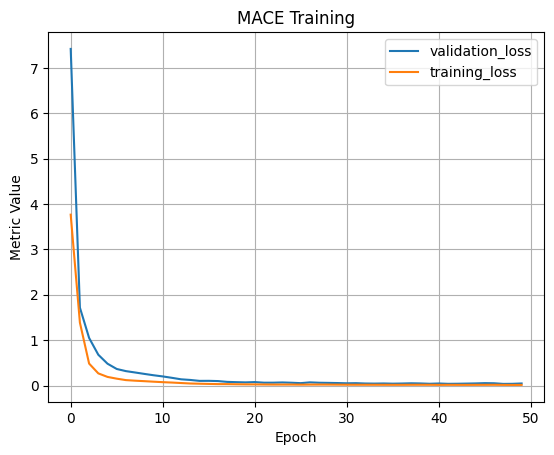

In [34]:
train_loss_data = []
valid_loss_data = []

for epoch in opt_data.keys():
  train_loss_data.append(opt_data[epoch]['loss'])
  valid_loss_data.append(eval_data[epoch]['loss'])

average_train_loss_data=[]

num_validation_configs = parameters_mace['valid_fraction'] * num_configs
num_train_configs = num_configs - num_validation_configs

for loss in train_loss_data:
  average_train_loss_data.append(np.sum(loss) / num_train_configs)

plt.figure(figsize=(10, 6))
plt.plot(valid_loss_data, label='validation_loss')
plt.plot(average_train_loss_data, label='training_loss')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('MACE Training')
plt.legend()
plt.grid(True)
plt.show()

### 3.5. Molecular Dynamics using MACE <a name="mace-md"></a>

#### 3.5.1 MACE Calculator
MACE models can run molecular dynamics or geometry optimisation through the ASE calculator. There is no need for model deployement unlike in NequIP.

In [35]:
init_conf = read(test_data, index=0)
init_conf

Atoms(symbols='Si64', pbc=True, cell=[10.861999859992501, 10.861999859992501, 10.861999859992501], calculator=SinglePointCalculator(...))

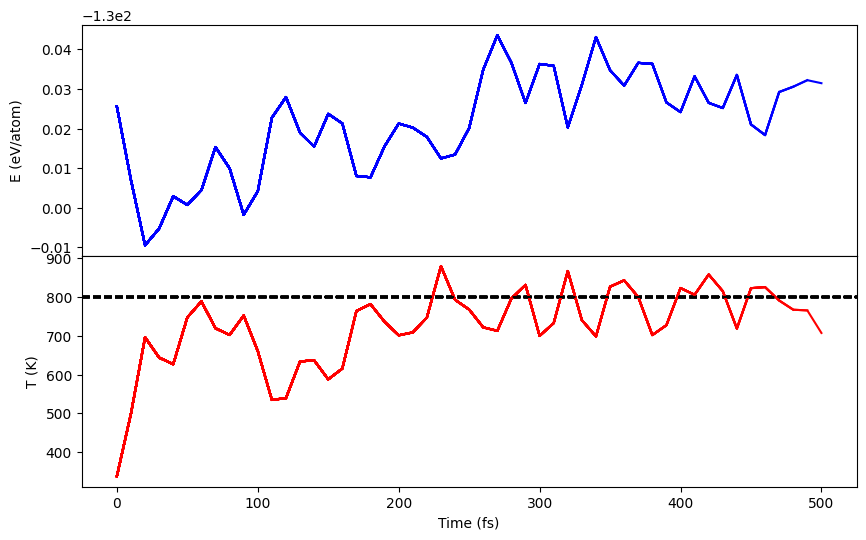

MD finished in 1.00 minutes!


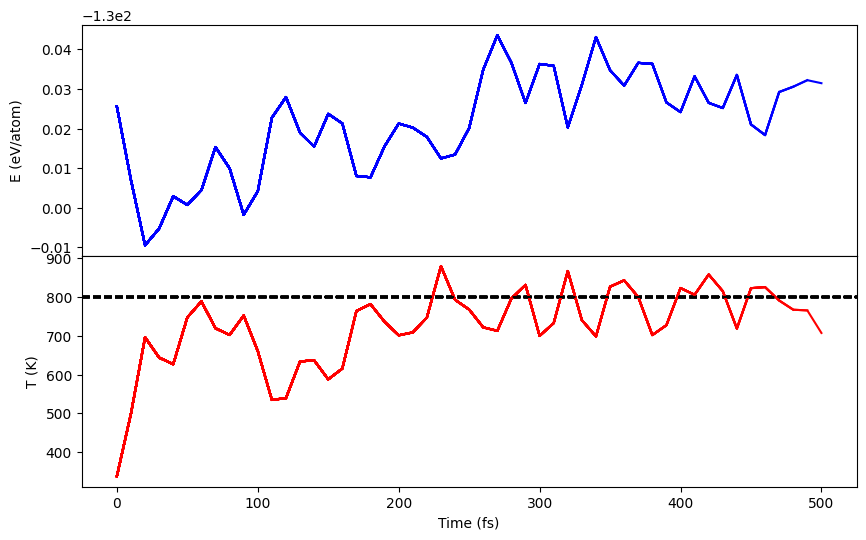

In [36]:
from mace.calculators import MACECalculator

# Specify the path to the pre-trained MACE model
mace_model = mace_train_dir / f"{parameters_mace['name']}_compiled.model"

# Initialize the MACE calculator with the specified model
mace_calc = MACECalculator(model_paths=[mace_model], device=device, default_dtype="float32")

# Call the simpleMD function to perform a molecular dynamics simulation
simpleMD(init_conf, temp=800, calc=mace_calc, fname= 'mace/results/mace_md_si_800K.xyz', s=10, T=500)

### 3.6. MACE Foundational Models <a name="mace-foundational"></a>

These are a single general-purpose ML model, pre-trained on a public database of 150k inorganic crystals, that is capable of running stable molecular dynamics on molecules and materials. We will be using one such model called [**MACE-MP: Materials Project Force Fields**](https://arxiv.org/abs/2401.00096) to demonstrate the power and generalizability of MACE.

In [37]:
init_conf = read(test_data, index=0)
init_conf

Atoms(symbols='Si64', pbc=True, cell=[10.861999859992501, 10.861999859992501, 10.861999859992501], calculator=SinglePointCalculator(...))

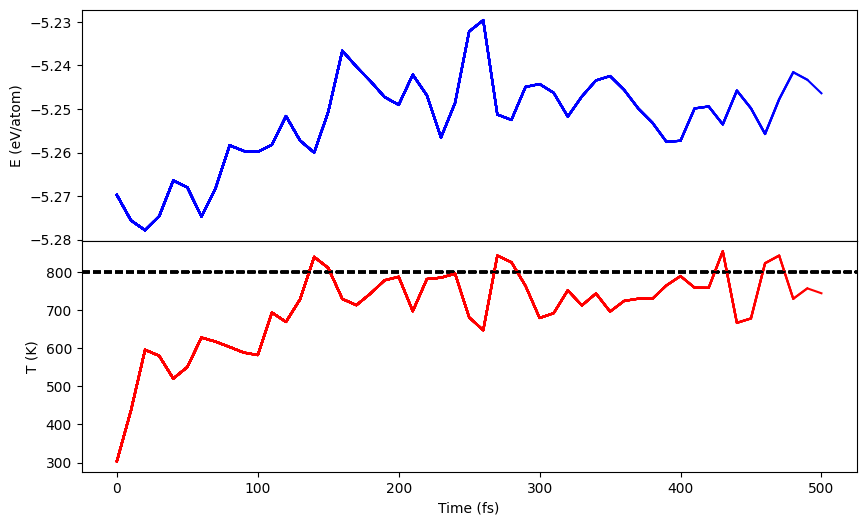

MD finished in 0.77 minutes!


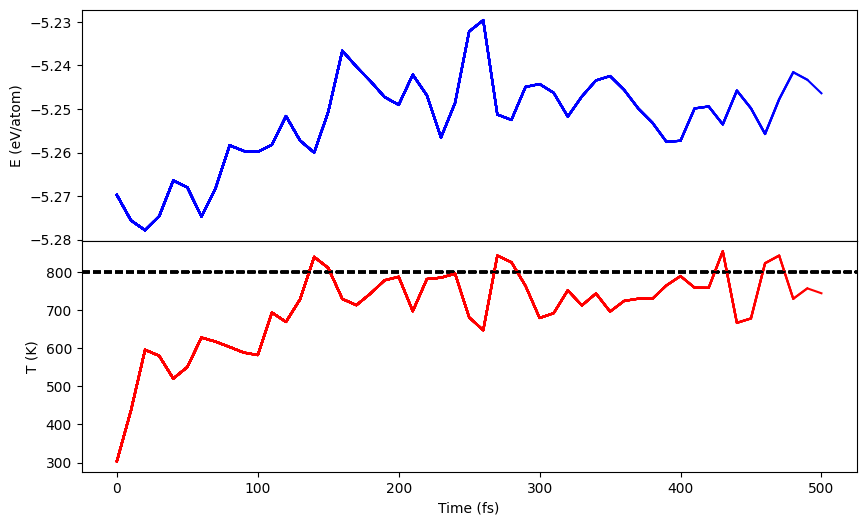

In [38]:
from mace.calculators import mace_mp
from ase import build

# Initialize the MACE-MP calculator
mace_mp_calc = mace_mp(device=device, default_dtype="float32")

simpleMD(init_conf, temp=800, calc=mace_mp_calc, fname ='mace/results/mace_mp_md_si_800K.xyz', s=10, T=500)


## 4. Exercises <a name="exercises"></a>







### 4.1. Evaluating NequIP and MACE <a name="ex-evaluate"></a>

We haven't tested the trained NequIP or MACE model. To test it we can use:

  - Use `nequip-evaluate` for NequIP model. [Refer this](https://github.com/mir-group/nequip?tab=readme-ov-file#evaluating-trained-models-and-their-error) or use `nequip-evaluate --help` for more reference.
    - Ensure you change the `dataset_file_name` to the test file.  
  - Use `eval_configs.py` for MACE model. [Refer this](https://mace-docs.readthedocs.io/en/latest/guide/evaluation.html).

Which model performs better?

### 4.2. Play with the hyperparamters for NequIP and MACE. <a name="ex-hyperparam"></a>

You tested the models in the previous exercise. But was the comparison fair?

How are they similar (look at the meaning of the hyperparamaters)? Can we get NequIP model by tweaking parameters of MACE?

*Hint:* *Look at the* `correlation` *hyperparameter*.

### 4.3. Training complex datasets <a name="ex-botnet"></a>

Download the BOTNET dataset:

```
!git clone https://github.com/davkovacs/BOTNet-datasets.git
```

The [BOTNET](https://github.com/davkovacs/BOTNet-datasets) collection of dataset used in the paper by [Batatia et.al](https://arxiv.org/abs/2205.06643). The collection contains the following datasets:

1. **Ethanol and Methanol:** Consists of two training datasets, first taken revMD17 dataset and was sampled from a long 500 K Ab Initio molecular dynamics trajectory and the second training set contains the 1000 ethanol geometries of the first training set but is augmented by 300 K methanol geometries also sampled from 500 K Ab Initio molecular dynamics simulation.
2. **3BPA:** Dataset contains snapshots of a large flexible drug-like organic molecule sampled from different temperature molecular dynamics trajectories.
3. **Acetylacetone:** Dataset contains data related to acetylacetone (acac), specifically focusing on proton transfer reactions between its tautomeric forms. This dataset includes configurations obtained from Ab Initio molecular dynamics simulations at 300 K.

Look at **[Ethanol dataset](https://github.com/davkovacs/BOTNet-datasets/tree/main/dataset_ethanol)**. Train on the `train_eth_meth.xyz` dataset. What will the parameters will you change? Don't focus on hyperparameters for now.

Evaluate and run the MD simulations on the `test_MD.xyz` file. Is the run stable? Now change the hyperparameters to make the model more complicated (increase the features, epoch, and layers). Observe the improvements.


## 5. BONUS: Visualizing `.xyz` files <a name="ovito"></a>

We can visualize the Molecular Dynamics file using softwares such as [OVITO](https://www.ovito.org/).

1. This can be done by downloading and installing OVITO software on your local device from the following website - [Download OVITO](https://www.ovito.org/#download)

2. After downloading it, open the application. [Refer this for usage instructions](https://www.ovito.org/manual).

3. Download `.xyz` trajectory files to your local device.

```
from google.colab import files
files.download(<filepath>)
```



4. Go to `Files`->`Load File...`-> Load the Trajectory File.

5. Play the animation.





In [41]:
# Downloading files from colab to local devices
from google.colab import files

files.download(nequip_results_dir /'nequip_md_si_800K.xyz')
files.download(mace_results_dir / 'mace_md_si_800K.xyz')
files.download(mace_results_dir /'mace_mp_md_si_800K.xyz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>